# AAE with no pretraining: Performance evaluation

Jacqueline R. M. A. Maasch | May 2022

## Preamble

In [1]:
# Importations.
import moses
import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from moses.metrics import weight, logP, SA, QED
from moses.metrics.utils import get_mol, mapper
from moses import get_dataset
from collections import OrderedDict
from tdc.chem_utils import MolFilter
import warnings
from tdc import Oracle
from rdkit import Chem                                                                                                                                                                   
from rdkit import RDLogger 
from random import sample
import tdc
from tdc import Evaluator
from tdc.single_pred import HTS
from importlib.metadata import version

In [2]:
# View versioning.
print("\npython version:", sys.version)
print("\n--- LIBRARY VERSIONS ---")
print("tdc:         ", version("PyTDC"))
print("numpy:       ", version("numpy"))
print("pandas:      ", version("pandas"))
print("moses:       ", version("molsets"))
print("rdkit:       ", version("rdkit-pypi"))
print("scipy:       ", version("scipy"))
print("seaborn:     ", version("seaborn"))
print("matplotlib:  ", version("matplotlib"))


python version: 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]

--- LIBRARY VERSIONS ---
tdc:          0.3.6
numpy:        1.22.3
pandas:       1.2.4
moses:        0.3.1
rdkit:        2021.9.5.1
scipy:        1.7.2
seaborn:      0.11.1
matplotlib:   3.3.4


In [3]:
%%capture
# Installs.
#!python3.8 -m pip install fcd_torch
#!python3.8 -m pip install rxn4chemistry

## Define functions

In [58]:
def compute_tdc_metrics(generated, training):
    
    metrics_dict = dict()
    
    kl = Evaluator(name = "KL_Divergence")
    metrics_dict["KL divergence"] = kl(generated, training)

    uniqueness = Evaluator(name = "Uniqueness")
    metrics_dict["Uniqueness"] = uniqueness(generated)

    validity = Evaluator(name = "Validity")
    metrics_dict["Validity"] = validity(generated)

    novelty = Evaluator(name = "Novelty")
    metrics_dict["Novelty"] = novelty(generated, training)

    #fcd = Evaluator(name = "FCD_Distance")
    #metrics_dict["FCD distance"] = fcd(generated, training)

    diversity = Evaluator(name = "Diversity")
    metrics_dict["Diversity"] = diversity(generated)

    return metrics_dict


def remove_ungrammatical(generated):
    # Disable warnings.
    RDLogger.DisableLog("rdApp.*")  
    
    # Filter molecules.
    keep = []
    invalid_string = 0
    invalid_chemistry = 0
    for molecule in generated:
        m = Chem.MolFromSmiles(molecule, sanitize = False)
        if m is None:
            invalid_string += 1
        else:
            try:
                Chem.SanitizeMol(m)
                keep.append(molecule)
            except:
                invalid_chemistry += 1
                
    print("Total strings with invalid SMILES syntax:", invalid_string)
    print("Total strings with invalid chemistry:", invalid_chemistry)
    print("Total valid SMILES strings:", len(keep))
    print("Percent valid SMILES strings:", (len(keep) / len(generated)))
    
    return keep


def plot_distribution_basic(df, 
                            log_x = None, 
                            log_y = None, 
                            save_path = "./plt.pdf", 
                            save = False):
    
    sns.displot(data = df, 
                x = "Value", 
                hue = "Distribution", 
                col = "Metric",
                kind = "kde", 
                log_scale = (log_x, log_y),
                common_norm = True,
                fill = True,
                height = 5)
    if save:
        plt.savefig(save_path)
    else:
        plt.show()
    
    
def plot_distribution(df, 
                      log_x = None, 
                      log_y = None, 
                      save_path = "./plt.pdf", 
                      save = False):
    
    g = sns.FacetGrid(df.reset_index(), 
                      col = "Metric",
                      hue = "Distribution", 
                      sharex = False, 
                      sharey = False)
    g.map_dataframe(sns.kdeplot, 
                    "Value",
                    fill = True, 
                    log_scale = (log_x, log_y),
                    common_norm = True).add_legend()
    if save:
        plt.savefig(save_path)
    else:
        plt.show()

## Read data

### Generated molecules

In [5]:
# Read in generated molecules.
df_active = pd.read_csv("../aae/generated_molecules_100k/gen_active.csv")
df_inactive = pd.read_csv("../aae/generated_molecules_100k/gen_inactive.csv")

print(df_active.info())
display(df_active.head())

print(df_inactive.info())
display(df_inactive.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SMILES  100000 non-null  object
dtypes: object(1)
memory usage: 781.4+ KB
None


,SMILES
0,<unk>#csCSH1Occc3(O)3)C@CC2+([C@(H4O]3<pad><pa...
1,cc1cc()Occ(C)<pad><pad><pad><pad><pad><pad><pa...
2,Fn1(SC@H]cCc[c3<pad><pad><pad><pad><pad><pad><...
3,5cc113(O)2C<pad><pad><pad><pad><pad><pad><pad>...
4,4OO<pad><pad><pad><pad><pad><pad><pad><pad><pa...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SMILES  100000 non-null  object
dtypes: object(1)
memory usage: 781.4+ KB
None


,SMILES
0,s(Oc2ccccc2C2(C=N)N2CCC)1<pad><pad><pad><pad><...
1,]c1cc(=O)c(C1<pad><pad><pad><pad><pad><pad><pa...
2,C[C@H](OC]N[C@@]]1[C@]](C)C(CC(=O)c(O)[C@]H2CO...
3,=O]-1S(C)=O<pad><pad><pad><pad><pad><pad><pad>...
4,CNCc1cccc(FC12[C@@H]3C[C@@H](C)C(=O)[C@@]33CC(...


### Training data from TDC

In [6]:
df_active_train = pd.read_csv("../sars_data/actives_train.csv")
df_inactive_train = pd.read_csv("../sars_data/inactives_train.csv")

print(df_active_train.info())
display(df_active_train.head())
print(df_inactive_train.info())
display(df_inactive_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  132 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB
None


,SMILES
0,NC(=O)c1ccc(NC(=O)[C@@H]2CCCO2)cc1
1,Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl
2,COC(=O)Nc1sc(C)nc1-c1ccccc1
3,OC1CCN(Cc2ccsc2)CC1
4,CC(C(O)c1ccc(O)cc1)N1CCC(Cc2ccccc2)CC1.CC(C(O)...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  1758 non-null   object
dtypes: object(1)
memory usage: 13.9+ KB
None


,SMILES
0,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)c(=O)n1
1,COc1cc(Br)c(C[N+]2(CCOCCC3CCC4CC3C4(C)C)CCOCC2...
2,O=C1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2N1
3,COCC1=C(C(=O)OC(C)OC(=O)OC(C)C)N2C(=O)[C@@H](N...
4,c1nc(N2CCC2)c2[nH]cnc2n1


### Validation data

In [7]:
df_active_val = pd.read_csv("../sars_data/actives_val.csv")
df_inactive_val = pd.read_csv("../sars_data/inactives_val.csv")

print(df_active_val.info())
display(df_active_val.head())
print(df_inactive_val.info())
display(df_inactive_val.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  34 non-null     object
dtypes: object(1)
memory usage: 400.0+ bytes
None


,SMILES
0,O=C(CCl)N1CCN(Cc2cccc3ccccc23)CC1
1,O=C(CCl)N1CCN(S(=O)(=O)c2cccs2)CC1
2,C[C@H]1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c...
3,C/C=C/c1ccc(OC)cc1
4,Clc1cccc(CN2CCOCC2)c1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  440 non-null    object
dtypes: object(1)
memory usage: 3.6+ KB
None


,SMILES
0,CCC1(C)CC(=O)NC1=O
1,CC(=O)N[C@@H](CCC(N)=O)C(=O)O
2,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O
3,CC(C)n1cnc(S(N)(=O)=O)c1
4,Cc1ccc(=O)n(-c2ccccc2)c1


## Process data

In [17]:
# Remove padding.
remove_pad = lambda x: x.replace("<pad>", "")
df_active.SMILES = df_active.SMILES.map(remove_pad)
df_inactive.SMILES = df_inactive.SMILES.map(remove_pad)

In [19]:
# Listify.
actives_gen = list(df_active.SMILES)
inactives_gen = list(df_inactive.SMILES)

actives_train = list(df_active_train.SMILES)
inactives_train = list(df_inactive_train.SMILES)

actives_val = list(df_active_val.SMILES)
inactives_val = list(df_inactive_val.SMILES)

In [20]:
# Filter out molecules that do not pass RDKit checks.
# Some metrics will require this step.
print("--- de novo actives ---")
actives_gen_grammatical = remove_ungrammatical(actives_gen)
print("\n--- de novo inactives ---")
inactives_gen_grammatical = remove_ungrammatical(inactives_gen)
print("\n--- training actives ---")
actives_train_grammatical = remove_ungrammatical(actives_train)
print("\n--- training inactives ---")
inactives_train_grammatical = remove_ungrammatical(inactives_train)
print("\n--- validation actives ---")
actives_val_grammatical = remove_ungrammatical(actives_val)
print("\n--- validation inactives ---")
inactives_val_grammatical = remove_ungrammatical(inactives_val)

--- de novo actives ---
Total strings with invalid SMILES syntax: 94843
Total strings with invalid chemistry: 1136
Total valid SMILES strings: 4021
Percent valid SMILES strings: 0.04021

--- de novo inactives ---
Total strings with invalid SMILES syntax: 96049
Total strings with invalid chemistry: 1771
Total valid SMILES strings: 2180
Percent valid SMILES strings: 0.0218

--- training actives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 132
Percent valid SMILES strings: 1.0

--- training inactives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 1758
Percent valid SMILES strings: 1.0

--- validation actives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 34
Percent valid SMILES strings: 1.0

--- validation inactives ---
Total strings with invalid SMILES syntax: 0
Total strings with i

## Global-level metrics

### MOSES metrics

In [21]:
moses.get_all_metrics?

Signature:
moses.get_all_metrics(
    gen,
    k=None,
    n_jobs=1,
    device='cpu',
    batch_size=512,
    pool=None,
    test=None,
    test_scaffolds=None,
    ptest=None,
    ptest_scaffolds=None,
    train=None,
)
Docstring:
Computes all available metrics between test (scaffold test)
and generated sets of SMILES.
Parameters:
    gen: list of generated SMILES
    k: int or list with values for unique@k. Will calculate number of
        unique molecules in the first k molecules. Default [1000, 10000]
    n_jobs: number of workers for parallel processing
    device: 'cpu' or 'cuda:n', where n is GPU device number
    batch_size: batch size for FCD metric
    pool: optional multiprocessing pool to use for parallelization

    test (None or list): test SMILES. If None, will load
        a default test set
    test_scaffolds (None or list): scaffold test SMILES. If None, will
        load a default scaffold test set
    ptest (None or dict): precalculated statistics of the test set. 

In [22]:
# Compute MOSES metrics for de novo actives.
start_time = time.time()
metrics_active = moses.get_all_metrics(gen = actives_gen, train = actives_train, test = actives_val)
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_active)

Complete in 89.70077967643738 seconds.


{'valid': 0.009739999999999971,
 'unique@1000': 0.17145790554414783,
 'unique@10000': 0.17145790554414783,
 'FCD/Test': 37.41504355664309,
 'SNN/Test': 0.03723723917732922,
 'Frag/Test': 0.032833453750424346,
 'Scaf/Test': 0.0,
 'FCD/TestSF': 46.76235079852759,
 'SNN/TestSF': 0.07137717393817843,
 'Frag/TestSF': 0.006931219957724388,
 'Scaf/TestSF': 0.0,
 'IntDiv': 0.9282397888373541,
 'IntDiv2': 0.7671993971267704,
 'Filters': 0.7176591375770021,
 'logP': 2.486604922092041,
 'SA': 3.1953149650737473,
 'QED': 0.28297369320472987,
 'weight': 307.4180991061723,
 'Novelty': 1.0}

In [23]:
# Compute MOSES metrics for de novo inactives.
start_time = time.time()
metrics_inactive = moses.get_all_metrics(gen = inactives_gen, train = inactives_train, test = inactives_val)
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_inactive)

Complete in 103.83566617965698 seconds.


{'valid': 0.010929999999999995,
 'unique@1000': 0.657,
 'unique@10000': 0.6486733760292772,
 'FCD/Test': 21.235466940505955,
 'SNN/Test': 0.1835810415368367,
 'Frag/Test': 0.3902215821702695,
 'Scaf/Test': 0.0057026594851220525,
 'FCD/TestSF': 32.15082195276734,
 'SNN/TestSF': 0.19106559648305477,
 'Frag/TestSF': 0.34938266475473156,
 'Scaf/TestSF': 0.0,
 'IntDiv': 0.9428642080725788,
 'IntDiv2': 0.8787681666715891,
 'Filters': 0.7346752058554438,
 'logP': 1.6599947468185985,
 'SA': 1.08895406883316,
 'QED': 0.1981709077805283,
 'weight': 215.58800001455552,
 'Novelty': 0.9943582510578279}

### TDC metrics

In [24]:
# NOTE: must subsample generative inactives to < 10k to get TDC functions to work.
# This is due to a glitch in TDC.
#inactives_gen_grammatical_10k = sample(inactives_gen_grammatical, 10000)

In [26]:
%%capture
# Throws error.
'''
ompute all metrics for active de novos vs their training data.
compute_tdc_metrics(actives_gen_grammatical, actives_train_grammatical)
'''

In [27]:
# KL divergence of active generated data and active training data.
kl = Evaluator(name = "KL_Divergence")
kl(actives_gen_grammatical, actives_train_grammatical)

RDKit WARNING: [19:00:17] WARNING: not removing hydrogen atom without neighbors
[19:00:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:00:17] WARNING: not removing hydrogen atom without neighbors
[19:00:17] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [19:00:17] Explicit valence for atom # 1 O, 3, is greater than permitted
[19:00:17] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit WARNING: [19:00:19] WARNING: not removing hydrogen atom without neighbors
[19:00:19] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [19:00:19] Explicit valence for atom # 1 O, 3, is greater than permitted
[19:00:19] Explicit valence for atom # 1 O, 3, is greater than permitted


0.022344437995587163

In [ ]:
%%capture
# Throws error.
'''
# Compute all metrics for inactive de novos vs their training data.
compute_tdc_metrics(inactives_gen_grammatical_10k, inactives_train_grammatical)
'''

In [29]:
# KL divergence of inactive generated data and inactive training data.
kl(inactives_gen_grammatical, inactives_train_grammatical)

RDKit ERROR: [19:00:38] Explicit valence for atom # 8 N, 4, is greater than permitted
[19:00:38] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [19:00:38] Explicit valence for atom # 11 C, 5, is greater than permitted
[19:00:38] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [19:00:39] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:00:39] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [19:00:39] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:00:39] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [19:00:39] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:00:39] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [19:00:39] Explicit valence for atom # 5 N, 4, is greater than permitted
[19:00:39] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [19:00:46] Explicit valence for

0.24361793840838972

In [30]:
# KL divergence of active training data and inactive training data.
kl(actives_train_grammatical, inactives_train_grammatical)

0.854377160131264

In [31]:
# KL divergence of active de novos and inactive training data.
kl(actives_gen_grammatical, inactives_train_grammatical)

RDKit WARNING: [19:00:54] WARNING: not removing hydrogen atom without neighbors
[19:00:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:00:55] WARNING: not removing hydrogen atom without neighbors
[19:00:55] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [19:00:55] Explicit valence for atom # 1 O, 3, is greater than permitted
[19:00:55] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit WARNING: [19:01:01] WARNING: not removing hydrogen atom without neighbors
[19:01:01] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [19:01:01] Explicit valence for atom # 1 O, 3, is greater than permitted
[19:01:01] Explicit valence for atom # 1 O, 3, is greater than permitted


0.05378226775510575

In [33]:
# KL divergence of inactive de novos and active training data.
kl(inactives_gen_grammatical, actives_train_grammatical)

RDKit ERROR: [19:01:13] Explicit valence for atom # 8 N, 4, is greater than permitted
[19:01:13] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [19:01:14] Explicit valence for atom # 11 C, 5, is greater than permitted
[19:01:14] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [19:01:14] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:01:14] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [19:01:14] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:01:14] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [19:01:15] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [19:01:15] Explicit valence for atom # 5 N, 4, is greater than permitted
[19:01:15] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:01:15] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [19:01:16] Explicit valence for

0.2171473265195969

In [35]:
# KL divergence of active de novos and inactive de novos.
kl(actives_gen_grammatical, inactives_gen_grammatical)

RDKit WARNING: [19:01:28] WARNING: not removing hydrogen atom without neighbors
[19:01:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:01:28] WARNING: not removing hydrogen atom without neighbors
[19:01:28] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [19:01:28] Explicit valence for atom # 1 O, 3, is greater than permitted
[19:01:28] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [19:01:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[19:01:29] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [19:01:30] Explicit valence for atom # 11 C, 5, is greater than permitted
[19:01:30] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [19:01:30] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [19:01:30] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [19:01:30] Explicit valence for atom # 1 C, 5,

0.3628466299470602

## Molecule-level metrics

### Synthetic accessibility

>Description: Synthetic Accessibility Score stands for how hard or how easy it is to synthesize a given molecule, based on a combination of the molecule’s fragments contributions. The oracle is caluated via RDKit, using a set of chemical rules defined by Ertl et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility]

In [48]:
# Synthetic accessibility.
sa = Oracle(name = "SA")

'''
sa_actives_gen = sa(actives_gen_grammatical)
sa_inactives_gen = sa(inactives_gen_grammatical)
sa_actives_train = sa(actives_train_grammatical)
sa_inactives_train = sa(inactives_train_grammatical)
'''

invalid = 0
sa_actives_gen = []
for molecule in actives_gen_grammatical:
    try:
        sa_one = sa(molecule)
        sa_actives_gen.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_actives_gen))

invalid = 0
sa_inactives_gen = []
for molecule in inactives_gen_grammatical:
    try:
        sa_one = sa(molecule)
        sa_inactives_gen.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_inactives_gen))

invalid = 0
sa_actives_train = []
for molecule in actives_train_grammatical:
    try:
        sa_one = sa(molecule)
        sa_actives_train.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_actives_train))

invalid = 0
sa_inactives_train = []
for molecule in inactives_train_grammatical:
    try:
        sa_one = sa(molecule)
        sa_inactives_train.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_inactives_train))

print()
sa_dict = {"Generated actives": sa_actives_gen,
           "Generated inactives": sa_inactives_gen,
           "Training actives": sa_actives_train,
           "Training inactives": sa_inactives_train}

for key,value in sa_dict.items():
    print(key, ":")
    print(value[:20], "\n")

RDKit WARNING: [19:17:35] WARNING: not removing hydrogen atom without neighbors
[19:17:35] WARNING: not removing hydrogen atom without neighbors



Total invalid: 3047
Total valid: 974

Total invalid: 1081
Total valid: 1099

Total invalid: 0
Total valid: 132

Total invalid: 0
Total valid: 1758

Generated actives :
[7.3284153846153846, 3.923225170503116, 6.467378682176442, 5.868476923076923, 8.479573080261886, 4.161787807865752, 7.3284153846153846, 2.772280115558061, 6.963984615384615, 7.3284153846153846, 5.868476923076923, 5.202260226641699, 6.667815384615385, 6.667815384615385, 6.635276923076923, 4.08999868818016, 6.963984615384615, 4.796106380487854, 6.667815384615385, 5.25302945741093] 

Generated inactives :
[4.452400087542523, 4.190354840243397, 1.5461538156987498, 2.702022616029206, 2.964737756564565, 3.2169054377631445, 7.3284153846153846, 5.868476923076923, 6.667815384615385, 5.868476923076923, 4.249435601452837, 5.6843459462804224, 4.860448548277273, 4.699425077367906, 4.525662042058823, 4.796106380487854, 3.7736516677662557, 3.936978564428631, 2.701044842026315, 4.023580503597284] 

Training actives :
[2.250644652759915

### QED

> Description: QED stands for Quantitative Estimate of Drug-likeness. The oracle is caluated via RDKit, using a set of chemical rules about drug-likeliness defined by Bickerton et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [38]:
# Address this error:
# RDKit ERROR: Explicit valence for atom # 14 C, 5, is greater than permitted.
inactives_gen_grammatical_keep = []
invalid_valence = 0
for molecule in inactives_gen_grammatical:
        m = Chem.MolFromSmiles(molecule, sanitize = True)
        try:
            m = Chem.RemoveHs(m)
            inactives_gen_grammatical_keep.append(molecule)
        except:
            invalid_valence += 1
print("Total de novo inactives with invalid valence:", invalid_valence)
print("Total de novo inactives with valid valence:", len(inactives_gen_grammatical_keep))

Total de novo inactives with invalid valence: 6
Total de novo inactives with valid valence: 2174


RDKit ERROR: [19:02:32] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:02:32] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [19:02:32] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:02:32] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [19:02:32] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:02:32] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [19:02:32] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:02:32] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [19:02:32] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:02:32] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [19:02:32] Explicit valence for atom # 5 N, 4, is greater than permitted
[19:02:32] Explicit valence for atom # 5 N, 4, is greater than permitted


In [41]:
# Address this error:
# RDKit ERROR: Explicit valence for atom # 14 C, 5, is greater than permitted.
actives_gen_grammatical_keep = []
invalid_valence = 0
for molecule in actives_gen_grammatical:
        m = Chem.MolFromSmiles(molecule, sanitize = True)
        try:
            m = Chem.RemoveHs(m)
            actives_gen_grammatical_keep.append(molecule)
        except:
            invalid_valence += 1
print("Total de novo actives with invalid valence:", invalid_valence)
print("Total de novo actives with valid valence:", len(actives_gen_grammatical_keep))

Total de novo actives with invalid valence: 1
Total de novo actives with valid valence: 4020


RDKit WARNING: [19:03:30] WARNING: not removing hydrogen atom without neighbors
[19:03:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:03:30] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [19:03:30] Explicit valence for atom # 1 O, 3, is greater than permitted
[19:03:30] WARNING: not removing hydrogen atom without neighbors
[19:03:30] Explicit valence for atom # 1 O, 3, is greater than permitted


In [42]:
# Quantitative Estimate of Drug-likeness.
qed = Oracle(name = "QED")
qed_actives_gen = qed(actives_gen_grammatical_keep) # Use only instances with proper valence.
qed_inactives_gen = qed(inactives_gen_grammatical_keep) # Use only instances with proper valence.
qed_actives_train = qed(actives_train_grammatical)
qed_inactives_train = qed(inactives_train_grammatical)

qed_dict = {"Generated actives": qed_actives_gen,
            "Generated inactives": qed_inactives_gen,
            "Training actives": qed_actives_train,
            "Training inactives": qed_inactives_train}

for key,value in qed_dict.items():
    print(key, ":")
    print(value[:20], "\n")

RDKit WARNING: [19:03:32] WARNING: not removing hydrogen atom without neighbors
[19:03:32] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:03:32] WARNING: not removing hydrogen atom without neighbors
[19:03:32] WARNING: not removing hydrogen atom without neighbors


Generated actives :
[0.33942358984550913, 0.3597849378839701, 0.33942358984550913, 0.33942358984550913, 0.33942358984550913, 0.28104491783005137, 0.25240152892555634, 0.33942358984550913, 0.3277476769246249, 0.33726523635157685, 0.33942358984550913, 0.33942358984550913, 0.33942358984550913, 0.33942358984550913, 0.33942358984550913, 0.33942358984550913, 0.33942358984550913, 0.32957849081585294, 0.33942358984550913, 0.33942358984550913] 

Generated inactives :
[0.3757777790675996, 0.33942358984550913, 0.3360378915285156, 0.3916450287186053, 0.4061642540637318, 0.33942358984550913, 0.33942358984550913, 0.33942358984550913, 0.4633035330620455, 0.436419546037416, 0.3597849378839701, 0.33942358984550913, 0.33942358984550913, 0.33942358984550913, 0.33942358984550913, 0.33942358984550913, 0.33942358984550913, 0.3277476769246249, 0.3975550616040572, 0.3277476769246249] 

Training actives :
[0.814913995911437, 0.7209997551181787, 0.8867424621741485, 0.7798427952514674, 0.08557107474966161, 0.795

### Octanol-water Partition Coefficient (LogP)

>Description: The penalized logP score measures the solubility and synthetic accessibility of a compound. The oracle is caluated via RDKit. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [49]:
# LogP.
logp = Oracle(name = "LogP")

'''
logp_actives_gen = logp(actives_gen_grammatical)
logp_inactives_gen = logp(inactives_gen_grammatical)
logp_actives_train = logp(actives_train_grammatical)
logp_inactives_train = logp(inactives_train_grammatical)
'''

invalid = 0
logp_actives_gen = []
for molecule in actives_gen_grammatical:
    try:
        logp_one = logp(molecule)
        logp_actives_gen.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_actives_gen))

invalid = 0
logp_inactives_gen = []
for molecule in inactives_gen_grammatical:
    try:
        logp_one = logp(molecule)
        logp_inactives_gen.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_inactives_gen))

invalid = 0
logp_actives_train = []
for molecule in actives_train_grammatical:
    try:
        logp_one = logp(molecule)
        logp_actives_train.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_actives_train))

invalid = 0
logp_inactives_train = []
for molecule in inactives_train_grammatical:
    try:
        logp_one = logp(molecule)
        logp_inactives_train.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_inactives_train))

print()
logp_dict = {"Generated actives": logp_actives_gen,
             "Generated inactives": logp_inactives_gen,
             "Training actives": logp_actives_train,
             "Training inactives": logp_inactives_train}

for key,value in logp_dict.items():
    print(key, ":")
    print(value[:20], "\n")

RDKit WARNING: [19:19:08] WARNING: not removing hydrogen atom without neighbors
[19:19:08] WARNING: not removing hydrogen atom without neighbors



Total invalid: 3047
Total valid: 974

Total invalid: 1081
Total valid: 1099

Total invalid: 0
Total valid: 132

Total invalid: 0
Total valid: 1758

Generated actives :
[-6.229620227953575, -2.653539816574265, -6.051714867816656, -5.496546478798415, -8.38925363427331, -3.8949041485491915, -6.229620227953575, -1.4893338822520295, -6.157242367197846, -6.229620227953575, -5.496546478798415, -5.149395394647295, -5.767617318560561, -5.767617318560561, -5.73520326931882, -2.2285901086298487, -6.157242367197846, -3.7814966822231053, -5.767617318560561, -4.529008412019673] 

Generated inactives :
[-3.878301419032463, -2.3937501688212275, 0.5475979594993705, -1.352266373937938, -0.5677721811464765, -1.7993141826237062, -6.229620227953575, -5.496546478798415, -5.767617318560561, -5.496546478798415, -2.5462026501456383, -3.451023848643214, -3.690875728547925, -4.631744076332721, -2.9465591618950726, -3.7814966822231053, -1.28802833490386, -2.050584776241499, -1.3944586730653459, -3.32646408279285

### Dictionary to dataframe

In [60]:
# SA.
df_sa = pd.DataFrame()
for key,value in sa_dict.items():
    df_sa = pd.concat([df_sa, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_sa["Metric"] = "SA"
display(df_sa)

,Distribution,Value,Metric
0,Generated actives,7.328415,SA
1,Generated actives,3.923225,SA
2,Generated actives,6.467379,SA
3,Generated actives,5.868477,SA
4,Generated actives,8.479573,SA
...,...,...,...
1753,Training inactives,1.919343,SA
1754,Training inactives,2.494935,SA
1755,Training inactives,4.908138,SA
1756,Training inactives,2.417861,SA


In [61]:
# QED.
df_qed = pd.DataFrame()
for key,value in qed_dict.items():
    df_qed = pd.concat([df_qed, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_qed["Metric"] = "QED"
display(df_qed)

,Distribution,Value,Metric
0,Generated actives,0.339424,QED
1,Generated actives,0.359785,QED
2,Generated actives,0.339424,QED
3,Generated actives,0.339424,QED
4,Generated actives,0.339424,QED
...,...,...,...
1753,Training inactives,0.736693,QED
1754,Training inactives,0.877740,QED
1755,Training inactives,0.675608,QED
1756,Training inactives,0.834182,QED


In [63]:
# LogP.
df_logp = pd.DataFrame()
for key,value in logp_dict.items():
    df_logp = pd.concat([df_logp, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_logp["Metric"] = "LogP"
display(df_logp)

,Distribution,Value,Metric
0,Generated actives,-6.229620,LogP
1,Generated actives,-2.653540,LogP
2,Generated actives,-6.051715,LogP
3,Generated actives,-5.496546,LogP
4,Generated actives,-8.389254,LogP
...,...,...,...
1753,Training inactives,1.354121,LogP
1754,Training inactives,1.682860,LogP
1755,Training inactives,-1.982381,LogP
1756,Training inactives,0.699492,LogP


In [64]:
# Aggregate all results.
df_metrics = pd.concat([df_sa, df_qed, df_logp]).reset_index(drop = True)
print(df_metrics.info())
display(df_metrics)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16010 entries, 0 to 16009
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Distribution  16010 non-null  object 
 1   Value         16010 non-null  float64
 2   Metric        16010 non-null  object 
dtypes: float64(1), object(2)
memory usage: 375.4+ KB
None


,Distribution,Value,Metric
0,Generated actives,7.328415,SA
1,Generated actives,3.923225,SA
2,Generated actives,6.467379,SA
3,Generated actives,5.868477,SA
4,Generated actives,8.479573,SA
...,...,...,...
16005,Training inactives,1.354121,LogP
16006,Training inactives,1.682860,LogP
16007,Training inactives,-1.982381,LogP
16008,Training inactives,0.699492,LogP


## Plot distributions

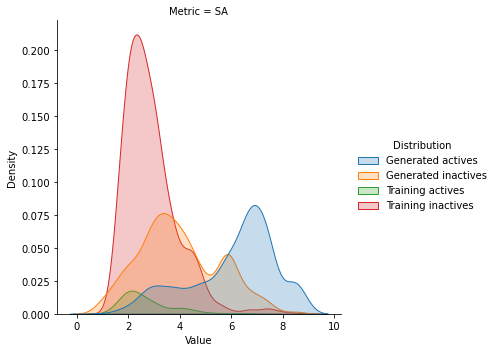

In [65]:
plot_distribution_basic(df_sa)

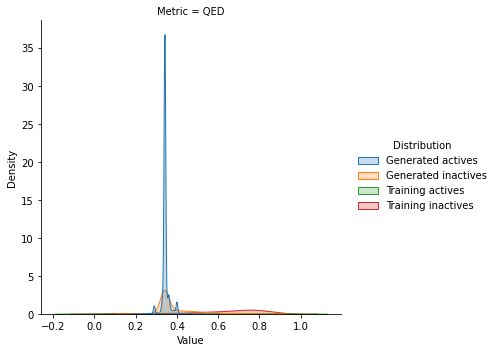

In [71]:
plot_distribution_basic(df_qed)

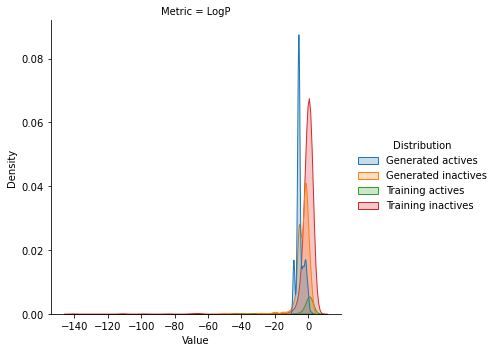

In [68]:
plot_distribution_basic(df_logp)

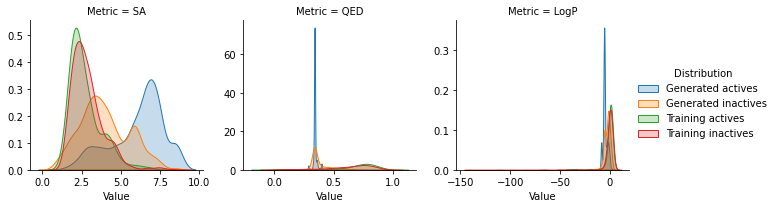

In [69]:
plot_distribution(df_metrics, save_path = "./aae_metrics.pdf", save = True)

## End of document